# Team 1 - Final Project
## Israel Romero Olvera
#### In this project I'll create a predictive model that will take Midi files from 4 Master composers and classify them by artist name based solely on the musical structure.

In [5]:
#Importing the required libraries
import os
import numpy as np
import random
import pandas as pd
import pretty_midi
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, LayerNormalization, Conv1D, MaxPooling1D, Dropout, LayerNormalization, LSTM, Bidirectional, Dense, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Preparing the directories to load the Midi files
rootdir=r'C:\Users\isral\AAI_511\Composer_Dataset\FinalDataset'

In [16]:
RANDOM_SEED = 75 #Define our random seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
# Creating a class to handle the MIDI loading
class MidiDataset:
    def __init__(self, path, num_epochs=10, seq_len=300, fs=10, batch_size=16, allow_repeat=False, max_files=170, verbose=1):
        self.path = path #root folder with subfolders for each composer
        self.seq_len = seq_len #number of time steps per piano roll
        self.fs = fs #frames per second for piano roll
        self.train_samples = [] #placeholder for the training sample midi paths
        self.train_labels = [] #placeholder for the training labels
        self.author_labels_idx = {} #placeholder for the id labels for training
        self.test_samples = [] #placeholder for the testing sample midi paths
        self.test_labels = [] #placeholder for the testing labels
        self.val_samples = [] #placeholder for the validation sample midi paths
        self.val_labels = [] #placeholder for the validation labels
        self.num_epochs = num_epochs #Setting the number of epochs that our model will use
        self.max_samples = max_files #Due to class imbalance, I'm "downsampling" by limiting the number of midi files loaded per author
        self.batch_size = batch_size #Setting the batch size
        self.allow_repeat = allow_repeat #Setting to configure the dataset to allow repeating or not
        self.verbose = verbose
        self.breakpoint_note = 60 #This is the note used as threshold to separate melody from accompaniment. C4 = 60
        self._load_data()
    def _load_data(self):
        #First, we load all the files in the provided path into the labels and midi sample paths, as well as creating the catalog of author labels
        labels, self.author_labels_idx, samples = self.load_path(self.path)
        self.plot_authors_distribution(labels, 'All imported midi') #We plot the distribution of melodies per artist
        
        #Setting other internal values
        self.learning_rate = 0.0001 #Establishing the learning rate

        #Split into train (80%), 
        self.train_samples, X_test, self.train_labels, y_test = train_test_split(samples, #Midi sample paths
                                                            labels,                        #Author targets
                                                            test_size=0.2,            #20% of the data (10% for test, 10% for validation)
                                                            random_state=RANDOM_SEED) #Set random seed
        #Next, breaking the temp set in half so validation and testing sets end with 10% of the original set each.
        self.test_samples, self.val_samples, self.test_labels, self.val_labels = train_test_split(X_test, #Midi sample paths
                                                            y_test,                        #Author targets
                                                            test_size=0.5,            #50% of the data (10% for test, 10% for validation from original set)
                                                            random_state=RANDOM_SEED) #Set random seed
        #Next, we prepare the dataset pairs for the model portion
        self.train_dataset = self.get_tf_dataset_train(batch_size=self.batch_size, shuffle=True)
        self.test_dataset = self.get_tf_dataset_test(batch_size=self.batch_size, shuffle=False)
        self.val_dataset = self.get_tf_dataset_val(batch_size=self.batch_size, shuffle=False)
        #self.num_samples_train = self.get_num_samples(self.train_dataset)
        #self.num_samples_test = self.get_num_samples(self.test_dataset)
        #self.num_samples_val = self.get_num_samples(self.val_dataset)
        #Let's prepare the Model definition
        self.model = self.model_builder()
    def plot_authors_distribution(self, train_labels, title):
        df = pd.DataFrame(train_labels, columns=['Author'])
        df.value_counts().sort_index().plot(kind='bar', title = f'Author sample counts - {title}')
        #plt.figure(figsize=(12, 6))
        plt.xticks(rotation = 0)
        plt.ylabel('Frequency')
        plt.xlabel(self.author_labels_idx)
        plt.tight_layout()
        plt.show()
    def load_path(self, path):
        labels = []
        label_to_idx = {}
        samples = []
        tmpCount = 0
        #First, we load all the subfolders list, which represents the authors list
        composer_dirs = [
            directory for directory in os.listdir(self.path)
            if os.path.isdir(os.path.join(self.path, directory))
        ]
        #Next, we load each individual midi file
        for idx, composer in enumerate(composer_dirs):
            label_to_idx[composer] = idx #Here we create a unique ID for each composer
            tmpCount = 0
            #Now, let's load all individual files in each composer's folder
            composer_path = os.path.join(path, composer)
            for fname in os.listdir(composer_path):
                if fname.endswith('.mid') or fname.endswith('.midi'): #Including any .MID or .MIDI files
                    file_path = os.path.join(composer_path, fname)
                    #if self.test_midi_file(file_path) == True: #If it's a valid Midi file, we add it. Otherwise, we skip it
                    if tmpCount < self.max_samples: #We're limiting the number of samples
                        samples.append(file_path)
                        labels.append(idx)
                    tmpCount=tmpCount+1
        return labels, label_to_idx, samples
    ##################################### MIDI FUNCTIONS ###########################################################
    #This function will convert the midi notes into a piano roll. Only pitch and duration of notes will be preserved, but other attributes like note velocity or midi channel will be lost.
    def midi_to_pianoroll(self, midi_path, plot=False):
         # Load MIDI
        midi_data = self.load_midi(midi_path)
        if midi_data is None:
            return None
        # Get first frame with a note
        first_active_frame = self.get_frame_first_note(midi_data)
    
        # Full piano roll, shape: (128, time)
        piano_roll = midi_data.get_piano_roll(fs=self.fs)
        piano_roll = piano_roll / 127.0  # Normalize velocity
        piano_roll = piano_roll[:, first_active_frame:]  # Trim leading silence
        piano_roll = piano_roll.T  # Now shape: (time, 128)
    
        # Pad or truncate to fixed length
        if piano_roll.shape[0] < self.seq_len:
            pad_width = self.seq_len - piano_roll.shape[0]
            piano_roll = np.pad(piano_roll, ((0, pad_width), (0, 0)))
        else:
            piano_roll = piano_roll[:self.seq_len]
    
        # Clip to valid MIDI range
        piano_roll = piano_roll[:, :128]
    
        # Split into accompaniment and melody
        melody = piano_roll[:, self.breakpoint_note:]        # C4 and above
        accompaniment = piano_roll[:, :self.breakpoint_note] # Below C4
    
        # Ensure both parts have the same number of pitch bins
        # We'll pad the smaller one with zeros on the right
        max_pitches = 128 # max(melody.shape[1], accompaniment.shape[1])
        if melody.shape[1] < max_pitches:
            pad = max_pitches - melody.shape[1]
            melody = np.pad(melody, ((0, 0), (0, pad)))
        if accompaniment.shape[1] < max_pitches:
            pad = max_pitches - accompaniment.shape[1]
            accompaniment = np.pad(accompaniment, ((0, 0), (0, pad)))
    
        # Now stack along the channel dimension: shape = (time, pitch_bins, 2)
        stacked_roll = np.stack([accompaniment, melody], axis=-1)
    
        #Plot merged piano roll (sum both layers)
        if plot:
            merged = accompaniment + melody
            self.plot_piano_roll(merged, title=f'Piano Roll (Merged) - {midi_path}')
        return stacked_roll    
    #Creating this function to visually represent a piano roll of a sample
    def plot_piano_roll(self, piano_roll, title="Piano Roll", save_path=None):
        # Handle 3D piano rolls by summing over channels
        if piano_roll.ndim == 3:
            # Combine accompaniment and melody for visualization
           piano_roll = np.sum(piano_roll, axis=-1)
    
        time_steps = piano_roll.shape[0]
        duration = time_steps / self.fs
        time_axis = np.linspace(0, duration, time_steps)
        print(f'Time Steps: {time_steps}, Frames per Second: {self.fs}, Duration: {duration:.2f}s')
    
        plt.figure(figsize=(12, 6))
        plt.imshow(piano_roll.T, aspect='auto', origin='lower',
                   extent=[0, duration, 0, piano_roll.shape[1]], cmap='gray_r')
        plt.xlabel('Time (s)')
        plt.ylabel('MIDI Note')
        plt.title(title)
        plt.tight_layout()
    
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
        
    def load_midi(self, midi_path):
        try:
            return pretty_midi.PrettyMIDI(midi_path)
        except Exception as e:
            print(f"⚠️ Skipping {midi_path}: {e}")
            return None
    def get_frame_first_note(self, midi_content):
        #Get all note start times
        note_start_times = [note.start for instrument in midi_content.instruments for note in instrument.notes]
        #Get the first note time
        first_note_time = min(note_start_times)
        #Calculate the frame in which the note shows up
        first_frame = int(first_note_time * self.fs)
        #Return the first frame
        return first_frame
    def generator(self, samples, labels):
        #for midi_path, label in zip(self.train_samples, self.train_labels):
        for midi_path, label in zip(samples, labels):
            piano_roll = self.midi_to_pianoroll(midi_path)
            yield piano_roll, label
    #This function builds the TensorFlow dataset
    def get_tf_dataset(self, samples, labels, batch_size=16, shuffle=True):
        output_signature = (
            tf.TensorSpec(shape=(self.seq_len, 128, 2), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        dataset = tf.data.Dataset.from_generator(
            lambda: self.generator(samples, labels),
            output_signature=output_signature
        )
        #The shuffle parameter will help the Neural Network training by shuffling the sample's order, preventing the model from seeing samples in the same order every epoch
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(samples))
            #dataset = dataset.repeat() #Preparing the dataset to be repeated indefinitely during epochs
            #dataset = dataset.shuffle(buffer_size=len(self.train_samples))
        dataset = dataset.batch(batch_size) #Preparing the dataset in the specified batches
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    def get_tf_dataset_train(self, batch_size=16, shuffle=True):
        return self.get_tf_dataset(self.train_samples, self.train_labels, batch_size, shuffle)
    def get_tf_dataset_test(self, batch_size=16, shuffle=False):
        return self.get_tf_dataset(self.test_samples, self.test_labels, batch_size, shuffle)
    def get_tf_dataset_val(self, batch_size=16, shuffle=False):
        return self.get_tf_dataset(self.val_samples, self.val_labels, batch_size, shuffle)
    def test_midi_file(self, file):
        tmpOpen = self.load_midi(file)
        if tmpOpen == None:
            return False
        return True
    #################################################### MODEL FUNCTIONS #######################################################
    def model_builder_old(self):
        n_classes = len(self.author_labels_idx)
    
        model = models.Sequential([
            #Updated input to match new piano roll format
            layers.Input(shape=(self.seq_len, 128, 2)),  # (time, pitch, channel)
            layers.Reshape((self.seq_len, 256)),         # Flatten pitch × channel
    
            #CNN Block
            layers.Conv1D(filters=64, kernel_size=9, dilation_rate=2, activation='relu', padding='same'),
            #BatchNormalization(),
            layers.MaxPooling1D(pool_size=4),
            LayerNormalization(),
            layers.Dropout(0.1),
    
            layers.Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
            #BatchNormalization(),
            layers.MaxPooling1D(pool_size=3),
            LayerNormalization(),
            layers.Dropout(0.1),
    
            #LSTM Block
            Bidirectional(layers.LSTM(256, return_sequences=True)),
            Bidirectional(layers.LSTM(128, return_sequences=True)),
            Bidirectional(layers.LSTM(64, return_sequences=False)),
    
            #Fully connected head
            layers.Dense(64, activation='linear'),
            layers.Dropout(0.3),
            layers.Dense(n_classes, activation='softmax')
        ])
        return model
    def model_builder(self):
        n_notes=128 #Max number of notes in Piano Roll
        n_channels=2 #Number of Piano Roll channels (melody + accompanyment)
        n_classes = len(self.author_labels_idx)
        
        input_layer = Input(shape=(self.seq_len, n_notes, n_channels))  # shape: (2400, 128, 2)
        # Reshape to (2400, 256) so Conv1D can be applied
        reshaped_input = Reshape((self.seq_len, n_notes * n_channels))(input_layer)  # (2400, 256)
    
        # === CNN Branch ===
        x_cnn = Conv1D(filters=64, kernel_size=9, dilation_rate=2, activation='relu', padding='same')(reshaped_input)
        x_cnn = MaxPooling1D(pool_size=4)(x_cnn)
        x_cnn = LayerNormalization()(x_cnn)
        x_cnn = Dropout(0.1)(x_cnn)
    
        x_cnn = Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu', padding='same')(x_cnn)
        x_cnn = MaxPooling1D(pool_size=3)(x_cnn)
        x_cnn = LayerNormalization()(x_cnn)
        x_cnn = Dropout(0.1)(x_cnn)
    
        x_cnn = layers.GlobalAveragePooling1D()(x_cnn)
    
        # === LSTM Branch ===
        # Reshape input to (seq_len, features)
        x_lstm = Reshape((self.seq_len, n_notes * n_channels))(input_layer)
    
        x_lstm = Bidirectional(LSTM(256, return_sequences=True))(x_lstm)
        x_lstm = Bidirectional(LSTM(128, return_sequences=True))(x_lstm)
        x_lstm = Bidirectional(LSTM(64, return_sequences=False))(x_lstm)
    
        # === Combine Branches ===
        merged = Concatenate()([x_cnn, x_lstm])
        x = Dense(64, activation='relu')(merged)
        x = Dropout(0.3)(x)
        output = Dense(n_classes, activation='softmax')(x)
    
        model = models.Model(inputs=input_layer, outputs=output)
        return model
    def train(self):
        #In this method, the class will compile the model and train it using the training set, returning the evaluation metrics.
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), metrics=['accuracy'])
        #Next, print the model summary
        self.model.summary()

        #Calculating the values for the epoch and validation steps
        train_steps = len(self.train_samples) // self.batch_size
        val_steps = len(self.val_samples) // self.batch_size
        
        #Preparing the Early Stopping if needed
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

        #Now, calculating the history after fitting the model with the training set
        history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=self.num_epochs,
            steps_per_epoch=train_steps,
            #batch_size=self.batch_size,
            validation_steps=val_steps,
            callbacks=[early_stopping],
            verbose=self.verbose
        )
        return self.evaluate(self.train_dataset, 'Training Dataset')

    def predict(self, dataset):
        #This method allows the model to predict the target outputs for the input X
        predictions = self.model.predict(dataset) #We execute and store the predictions
        predicted_labels = np.argmax(predictions, axis=1)
        return predicted_labels
    def test(self):
        #This method evaluates the predictions built with the testing set
        return self.evaluate(self.test_dataset, 'Testing Dataset')

    def evaluate(self, dataset, title=''):
        #This method evaluates the performance of the ANN with the selected parameters
        pred_labels = self.predict(dataset) #First, we perform the predictions
        true_labels = []
        #Next, we'll get the true labels directly from the dataset, which contains the tensor-label pair
        for _, label_batch in dataset:
            true_labels.extend(label_batch.numpy())
        true_labels = np.array(true_labels)
        #If we specify a title value means we also want to print a confusion matrix chart.
        if not title == '':
            self.print_confusion_matrix(true_labels, pred_labels, title)
        #Then, we used the actual values and predicted values to calculate all metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        #Finally, we return the metrics
        return np.round((accuracy, precision, recall, f1), decimals=2)
    def get_num_samples(self, dataset):
        sample_count = sum(1 for _ in dataset)
        return sample_count
    def print_num_samples(self):
        print(f'Training samples: {self.num_samples_train}, Testing samples: {self.num_samples_test}, Val samples: {self.num_samples_val}.')
    def print_confusion_matrix(self, true_labels, predicted_labels, title):
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.author_labels_idx.keys(), yticklabels=self.author_labels_idx.keys())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {title}')
        plt.show()

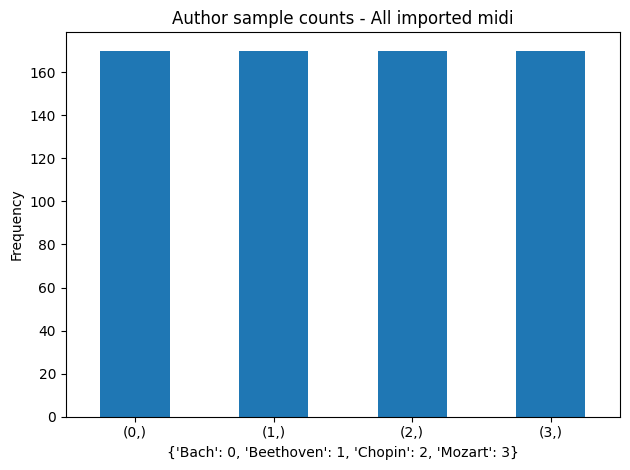

In [17]:
#For the model, I'll use 15 epochs, a frequency of 40 frames per second, and a duration of 60 seconds, which at 40 fps would be 2400 frames
midi_model = MidiDataset(path=rootdir, num_epochs=15, seq_len=2400, fs=40, batch_size=64, allow_repeat=False, max_files=170, verbose=1)

In [27]:
# Ensure tmpscore is not None and has 3 dimensions
if tmpscore is not None and tmpscore.ndim == 3:
    max_simultaneous_notes = 0
    note_counts_per_timestep = []

    for timestep in tmpscore:
        # timestep shape: (128, 2) → notes × channels
        # Count all values > 0 across both melody and accompaniment
        num_active_notes = np.sum(timestep > 0)
        note_counts_per_timestep.append(num_active_notes)

        # Update maximum if current count is higher
        if num_active_notes > max_simultaneous_notes:
            max_simultaneous_notes = num_active_notes

    print("Maximum number of notes played simultaneously:", max_simultaneous_notes)
else:
    print("Error: Invalid or missing piano roll data.")


Maximum number of notes played simultaneously: 4


Time Steps: 2400, Frames per Second: 40, Duration: 60.00s


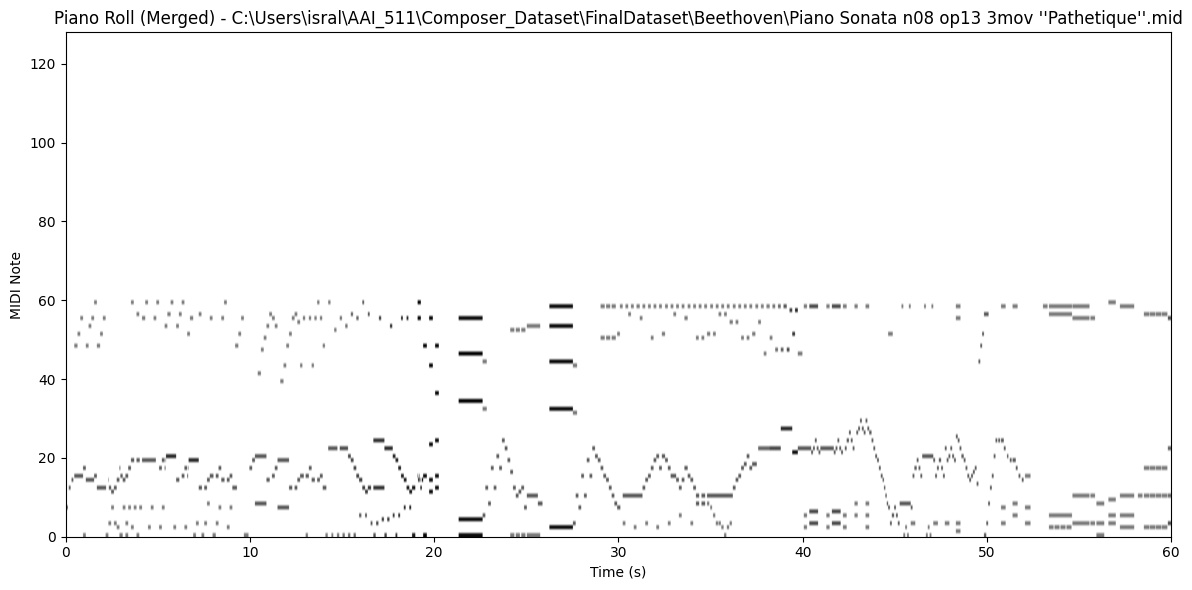

In [18]:
#Plotting a Piano Roll
tmpArr = midi_model.midi_to_pianoroll(midi_model.val_samples[0], plot=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2400, 128, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 2400, 256) │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2400, 64)  │    147,520 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 600, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 600, 64)   │        128 │ max_pooling1d[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 600, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 600, 128)  │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 200, 128)  │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 2400, 256) │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 2400, 512) │  1,050,624 │ reshape_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 128)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 2400, 256) │    656,384 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │    164,352 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,060,676 (7.86 MB)

 Trainable params: 2,060,676 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


C:\Users\isral\.conda\envs\IRO\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1223s 141s/step - accuracy: 0.2818 - loss: 1.4005 - val_accuracy: 0.4688 - val_loss: 1.3126
Epoch 2/15
1/8 ━━━━━━━━━━━━━━━━━━━━ 11:03 95s/step - accuracy: 0.2188 - loss: 1.3759

C:\Users\isral\.conda\envs\IRO\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.2188 - loss: 1.3759 - val_accuracy: 0.4688 - val_loss: 1.3047
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1280s 141s/step - accuracy: 0.4484 - loss: 1.2894 - val_accuracy: 0.5000 - val_loss: 1.2441
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.4375 - loss: 1.2511 - val_accuracy: 0.5156 - val_loss: 1.2366
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1274s 140s/step - accuracy: 0.5086 - loss: 1.2051 - val_accuracy: 0.5000 - val_loss: 1.1777
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.6875 - loss: 1.0901 - val_accuracy: 0.5312 - val_loss: 1.1696
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1277s 140s/step - accuracy: 0.5984 - loss: 1.1118 - val_accuracy: 0.5625 - val_loss: 1.1097
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.5938 - loss: 0.9965 - val_accuracy: 0.5781 - val_loss: 1.1031
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1287s 140s/step - accuracy: 0.6015 - loss: 1.0392 - val_accuracy: 0.5469 - val_loss: 1.0537

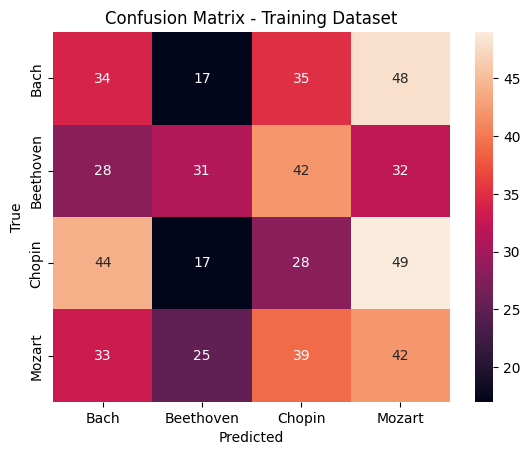

In [19]:
training_accuracy, training_precision, training_recall, training_f1 = midi_model.train()

C:\Users\isral\.conda\envs\IRO\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


C:\Users\isral\.conda\envs\IRO\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


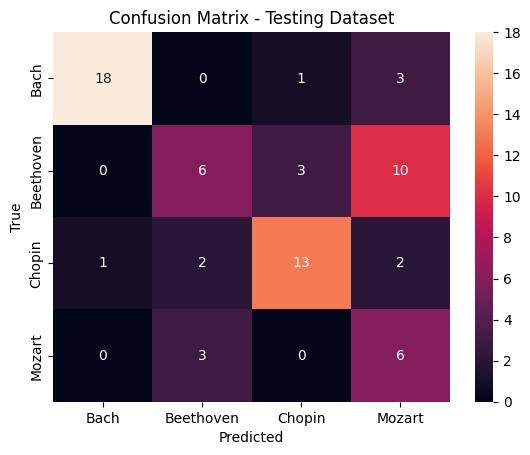

In [20]:
testing_accuracy, testing_precision, testing_recall, testing_f1 = midi_model.test()

In [21]:
print(f'Training Set metrics. Accuracy: {training_accuracy}, Precision: {training_precision}, Recall: {training_recall}, F1: {training_f1}')
print(f'Testing Set metrics. Accuracy: {testing_accuracy}, Precision: {testing_precision}, Recall: {testing_recall}, F1: {testing_f1}')

Training Set metrics. Accuracy: 0.25, Precision: 0.26, Recall: 0.25, F1: 0.25
Testing Set metrics. Accuracy: 0.63, Precision: 0.7, Recall: 0.63, F1: 0.65


C:\Users\isral\.conda\envs\IRO\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step


C:\Users\isral\.conda\envs\IRO\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


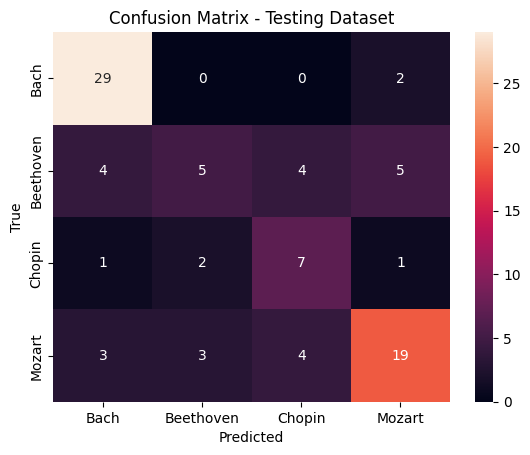

array([0.67, 0.66, 0.67, 0.66])

In [14]:
midi_model.evaluate(midi_model.test_dataset, 'Testing Dataset')


In [ ]:
#for piano_rolls, labels in midi_model.train_dataset.take(1):
#    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
#    print('Batch labels:', labels)                        # (batch_size,)
#    print('Labels batch shape:', labels.shape)

for piano_rolls, labels in midi_model.test_dataset.take(1):
    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
    print('Batch labels:', labels)                        # (batch_size,)
    print('Labels batch shape:', labels.shape)
#for piano_rolls, labels in midi_model.val_dataset.take(1):
#    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
#    print('Batch labels:', labels)                        # (batch_size,)
#    print('Labels batch shape:', labels.shape)


In [ ]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)
print(val_dataset.element_spec)

In [ ]:
sample_count = 0
for piano_rolls, labels in val_dataset:
    sample_count += piano_rolls.shape[0]  # Number of samples in this batch

print("Total samples:", sample_count)